In [95]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches

# Helper Functions

In [3]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Calculate differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Calculate distance
    distance = R * c
    return distance

In [5]:
df = pd.read_excel("swainson's hawk.xlsx")
df['date'] = pd.to_datetime(df['date'])
df.head()

,species,birdID,date,longitude,latitude
0,Swainson's hawk,SW16,1996-10-08,-98.184,28.840
1,Swainson's hawk,SW16,1996-10-09,-98.877,29.120
2,Swainson's hawk,SW16,1996-10-10,-99.299,25.879
3,Swainson's hawk,SW16,1996-10-11,-98.326,22.770
4,Swainson's hawk,SW16,1996-10-12,-96.021,17.831


In [6]:
def migratory_stretch_estimator(df):
    # Calculate distance and time difference for each bird ID
    result_data = []

    # Iterate over each unique bird ID
    for bird_id, group_df in df.groupby('birdID'):
        first_entry = True
        # Calculate distance and time difference for each row in the group
        for index, row in group_df.iterrows():
            if first_entry:
                prev_longitude = row['longitude']
                prev_latitude = row['latitude']
                prev_date = row['date']
                first_entry = False
            else:
                distance = haversine(row['longitude'], row['latitude'], prev_longitude, prev_latitude)

                time_difference = (row['date'] - prev_date).days
                
                result_data.append({
                    'birdID': bird_id,
                    'distance': distance,
                    'time': time_difference
                })
                
                # Update previous values for the next iteration
                prev_longitude = row['longitude']
                prev_latitude = row['latitude']
                prev_date = row['date']

    # Create a new DataFrame from the result data
    result_df = pd.DataFrame(result_data)
    return result_df

In [7]:
SWH_dist = migratory_stretch_estimator(df)
SWH_dist

,birdID,distance,time
0,SW16,77.196132,1
1,SW16,73.753169,1
2,SW16,120.422288,1
3,SW16,265.087782,1
4,SW16,1272.416610,9
...,...,...,...
158,SW25,483.053535,6
159,SW25,419.507241,7
160,SW25,1550.947945,6
161,SW25,1504.535960,7


In [8]:
SWH_dist[SWH_dist['time'] < 3][SWH_dist['distance'] < 500]['distance'].max()

C:\Users\Yashraj Deshmukh\AppData\Local\Temp\ipykernel_4180\4016690045.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  SWH_dist[SWH_dist['time'] < 3][SWH_dist['distance'] < 500]['distance'].max()


477.0961216935548

In [9]:
SWH_dist[SWH_dist['distance'] < 478]['distance'].median() , SWH_dist[SWH_dist['distance'] < 478]['distance'].mean()

(134.635304338803, 162.19031381977132)

In [77]:
SWH_migratory_stretch = 478
SWH_median_migration = 135
SWH_mean_migration = 163

In [75]:
def create_migration_network(data, max_migration, keep=False):
    groups = []
    for bird_id, group_df in data.groupby('birdID'):
        groups.append(group_df)

    # Create an empty graph
    migration_network = nx.Graph()

    # Iterate over each group of bird movements
    for bird_group in groups:
        # Extract latitude and longitude coordinates for the bird's movements
        points = list(zip(bird_group['latitude'], bird_group['longitude']))
        
        if keep:
            # Add edges based on the original connections
            for i in range(len(points) - 1):
                migration_network.add_edge(points[i], points[i + 1])
        else:
            # Add nodes to the network
            for point in points:
                migration_network.add_node(point)

    # Iterate again to add additional edges based on maximum migration distance
    all_nodes = migration_network.nodes()
    for node1 in all_nodes:
        for node2 in all_nodes:
            if node1 != node2:
                # Calculate distance between two nodes using Haversine formula
                distance = haversine(node1[0], node1[1], node2[0], node2[1])
                # If distance is less than max_migration, add an edge between the two nodes
                if distance < max_migration:
                    migration_network.add_edge(node1, node2)

    return migration_network

In [78]:
SWH_network = create_migration_network(df, SWH_migratory_stretch)
print(SWH_network)

Graph with 167 nodes and 1050 edges


In [79]:
# Add edges to the SWH_network
SWH_network.add_edge((16.873, -93.871), (34.712, -113.315))
SWH_network.add_edge((28.277, -102.317), (37.669, -120.664))
SWH_network.add_edge((25.437, -103.972), (35.15, -118.945))
SWH_network.add_edge((25.062, -107.464), (33.85, -116.99))
print(SWH_network)

Graph with 167 nodes and 1054 edges


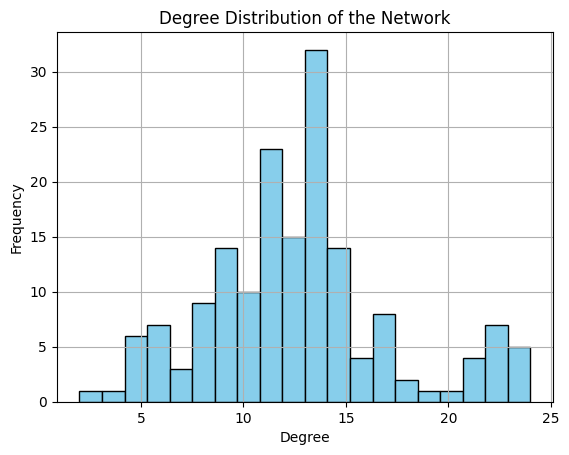

In [80]:
degrees = dict(SWH_network.degree())
# Plot degree distribution
plt.hist(list(degrees.values()), bins=20, color='skyblue', edgecolor='black')
plt.title('Degree Distribution of the Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
def plot_migration_network_on_world_map(migration_network):
    plt.figure(figsize=(10, 8))
    
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    nx.draw_networkx_nodes(migration_network, pos, node_size=10, node_color='blue', alpha=0.5)
    nx.draw_networkx_edges(migration_network, pos, width=0.5, alpha=0.5)

    plt.title('Migration Network on World Map')
    plt.show()

In [73]:
len(list(nx.connected_components(SWH_network)))

1

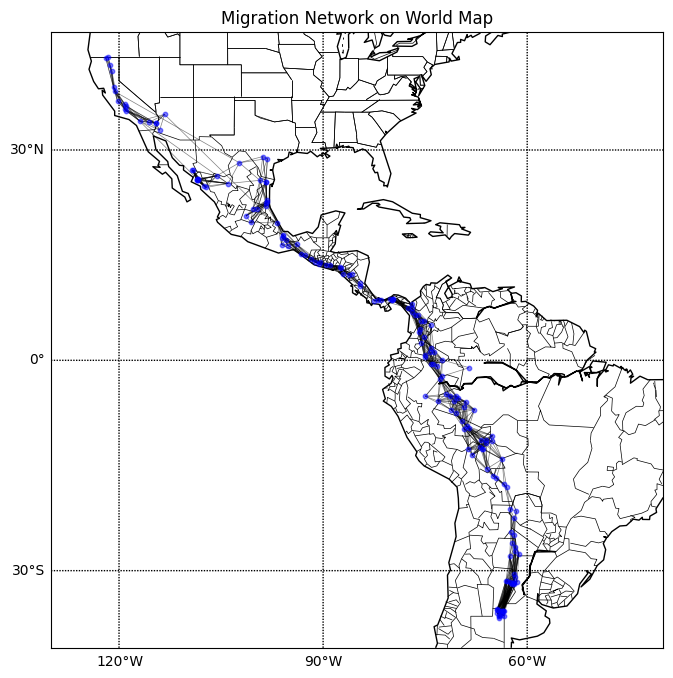

In [81]:
plot_migration_network_on_world_map(SWH_network)

In [46]:
def estimate_k_bisection(d_prime, tolerance=0.01, max_iterations=1000):
    # Define the function f(d) = e^-kd
    def f(d, k):
        return math.exp(-k * d)
    
    # Define the target value
    target_value = 0.5
    
    # Define the initial bounds for k
    lower_bound = 0
    upper_bound = 1
    # lies in 0 to 1 since k has dimension (km)^-1
    
    # Perform bisection search
    iterations = 0
    while iterations < max_iterations:
        # Calculate the midpoint and the corresponding function value
        midpoint = (lower_bound + upper_bound) / 2
        result = f(d_prime, midpoint)
        
        # Check if the result is within tolerance of the target value
        if abs(result - target_value) < tolerance:
            return midpoint
        
        # Update the bounds based on the sign of the result
        if result < target_value:
            upper_bound = midpoint
        else:
            lower_bound = midpoint
        
        iterations += 1
    
    # If max_iterations is reached without convergence, return None
    return None

In [47]:
k_SWH = estimate_k_bisection(SWH_median_migration)
print("Estimated value of Dispersal Constant, k:", k_SWH)

n_SWH = df["birdID"].nunique()
print("No. of Swainson's Hawk, n :", n_SWH)

Estimated value of Dispersal Constant, k: 0.005126953125
No. of Swainson's Hawk, n : 4


In [21]:
#  p ( d )  is the probability of dispersing at least distance d, and k is the dispersal coefficient
def p(d, k):
    return math.exp(-k * d)

print(p(SWH_median_migration, k_SWH))
print(p(SWH_median_migration, 1/SWH_mean_migration))

print(p(SWH_migratory_stretch, k_SWH))
print(p(SWH_migratory_stretch, 1/SWH_mean_migration))

# max dist
print(p(2186, k_SWH))
print(p(2186, 1/SWH_mean_migration))

# min dist
print(p(0.68, k_SWH))
print(p(0.68, 1/SWH_mean_migration))

0.5005045087004147
0.436825770062579
0.08623461690089532
0.05326289535477274
1.3571758146295913e-05
1.498504503605287e-06
0.996519742060629
0.9958369106413459


In [61]:
def weight_of_edge(n, k, d):
    return n * p(d, k)

for u, v in SWH_network.edges():
    weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    SWH_network[u][v]['weight'] = weight

[2.733566414829803, 0.6746163924544545, 0.49270817921050375, 0.6450883120568042, 0.6540633706143847, 0.6227266965486709, 0.6705217510436223, 0.5444951526861428, 0.5517802777242576, 0.6333350190646168]


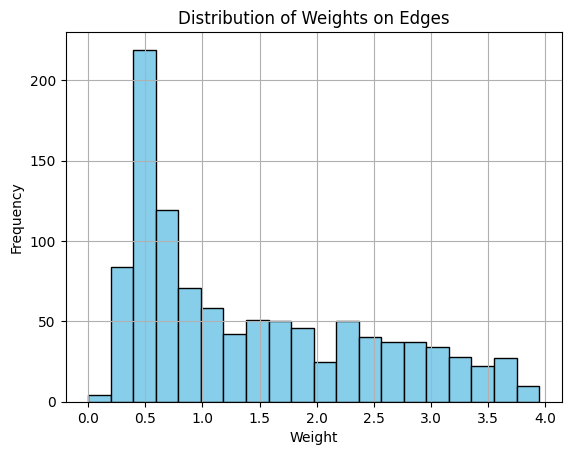

In [62]:
# Extract the weights from the edges
weights = [SWH_network[u][v]["weight"] for u,v in SWH_network.edges()]

print(weights[:10])

# Plot the distribution of weights
plt.hist(weights, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Weights on Edges')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

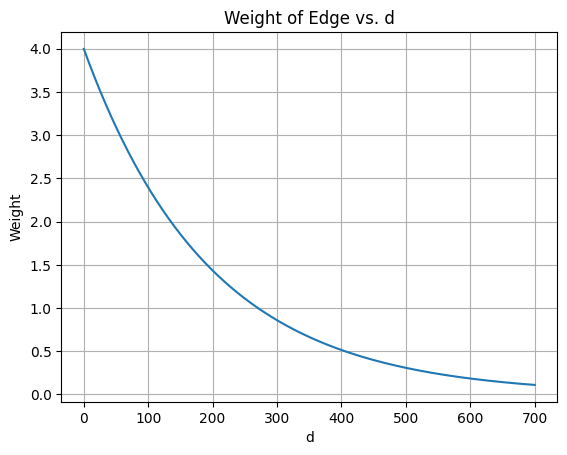

In [25]:
d_values = np.linspace(0.1, 700, 7000)  # Vary d from 0.1 to 700
weights_ = [weight_of_edge(n_SWH, k_SWH, d) for d in d_values]

plt.plot(d_values, weights_)
plt.xlabel('d')
plt.ylabel('Weight')
plt.title('Weight of Edge vs. d')
plt.grid(True)
plt.show()

In [88]:
def plot_weighted_migration_network_on_world_map(migration_network):
    """
    Plot the migration network on a world map using latitude and longitude values for node positions.
    
    Parameters:
        - migration_network: NetworkX graph representing the migration network.
    """
    # Create a new figure
    plt.figure(figsize=(10, 20))

    # Create a Basemap instance for world map projection
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-58)

    # Draw coastlines, countries, and states with reduced opacity
    m.drawcoastlines(linewidth=0.2)
    m.drawcountries(linewidth=0.2)
    m.drawstates(linewidth=0.2)

    # Draw meridians and parallels
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert latitude and longitude coordinates to map coordinates
    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}
    
    # Create color maps for edges and nodes based on weight and degree ranges
    edge_colors = ['#ff9896', '#ffbb78', 'brown', 'indigo', '#9edae5', '#aec7e8']  # Define colors for edge weight ranges
    degree_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Define colors for node degree ranges
    
    # Define edge weight ranges and corresponding labels
    edge_weight_ranges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, float('inf'))]
    edge_labels = [f'{start}-{end}' if end != float('inf') else f'>{start}' for start, end in edge_weight_ranges]
    
    # Define node degree ranges and corresponding labels
    node_degree_ranges = [(0,5),(6, 10), (11, 15), (16, 20), (21, 25)]
    degree_labels = [f'{start}-{end}' for start, end in node_degree_ranges]
    
    # Draw nodes
    for node, degree in migration_network.degree():
        # Assign node size based on degree
        node_size = 2 * degree
        
        # Assign color based on node degree range
        for i, (start, end) in enumerate(node_degree_ranges):
            if start <= degree <= end:
                node_color = degree_colors[i]
                break
        
        nx.draw_networkx_nodes(migration_network, pos, nodelist=[node], node_size=node_size, node_color=node_color, alpha=0.5)
    
    # Draw edges
    for edge in migration_network.edges():
        # Get edge weight
        weight = migration_network[edge[0]][edge[1]].get('weight', 1000)
        
        # Assign color based on edge weight range
        for i, (start, end) in enumerate(edge_weight_ranges):
            if start <= weight < end:
                edge_color = edge_colors[i]
                break
        
        nx.draw_networkx_edges(migration_network, pos, edgelist=[edge], width=weight + 1, edge_color=edge_color, alpha=0.5) #(1 if (weight<2 and weight>1) else 0.01))
    
    # Create legend patches for edge colors and node degrees
    edge_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(edge_colors, edge_labels)]
    degree_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(degree_colors, degree_labels)]
    
    # Draw legend for both edge colors and node degrees
    plt.legend(handles=edge_patches + degree_patches, title='Edge Weights and\nNode Degrees', loc='upper right', fontsize='small')

    plt.title('Migration Network on World Map')
    plt.show()

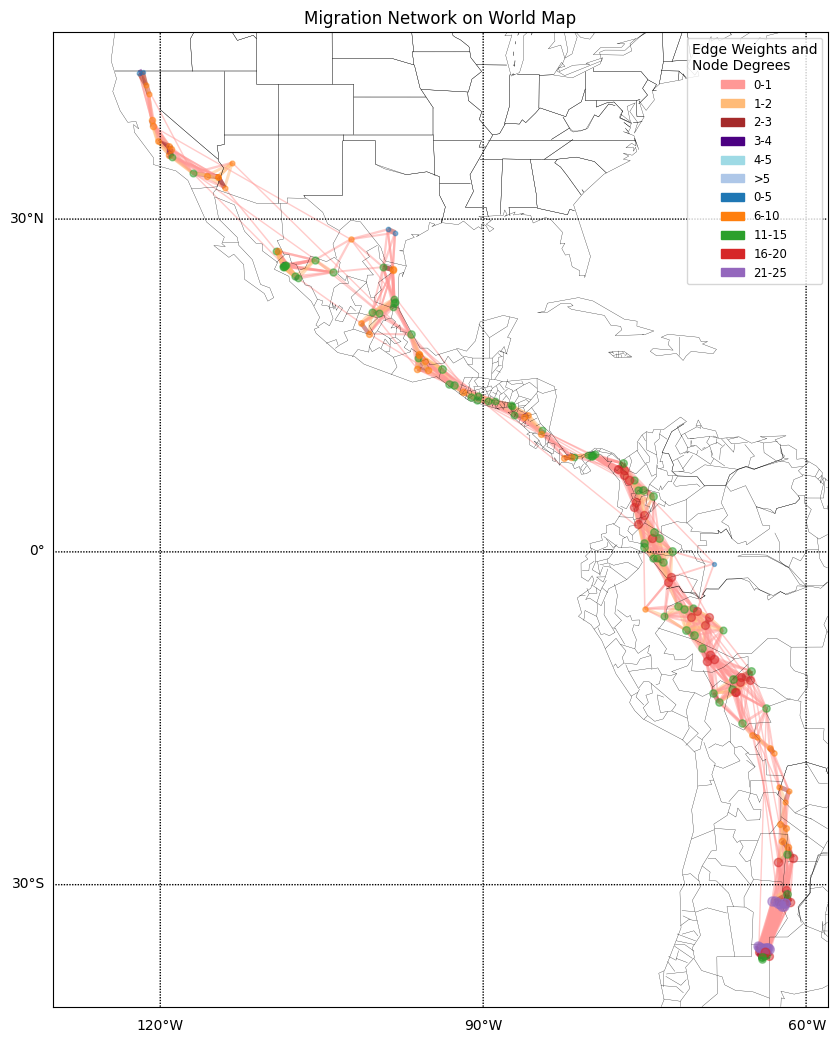

In [50]:
plot_weighted_migration_network_on_world_map(SWH_network)

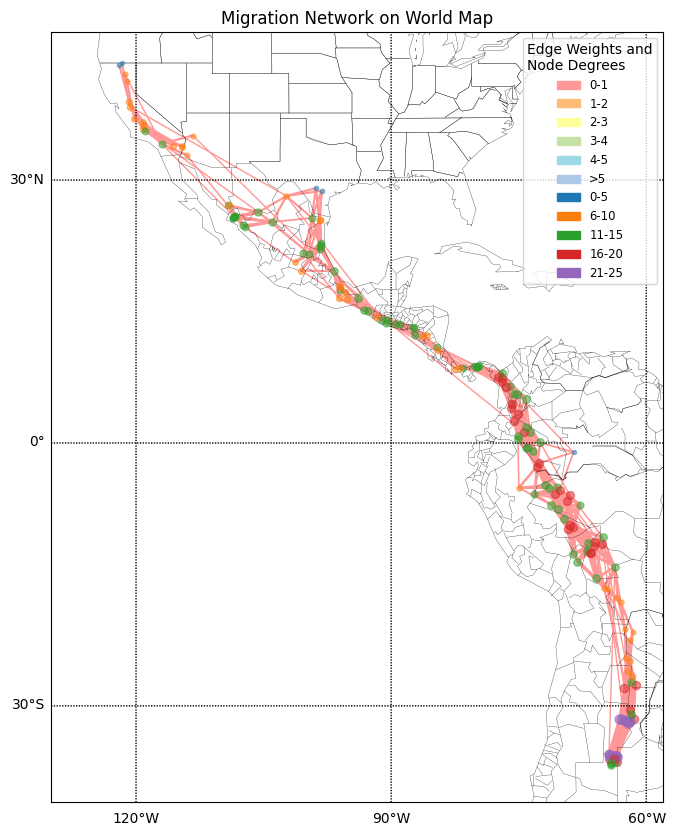

In [33]:
plot_weighted_migration_network_on_world_map(SWH_network)

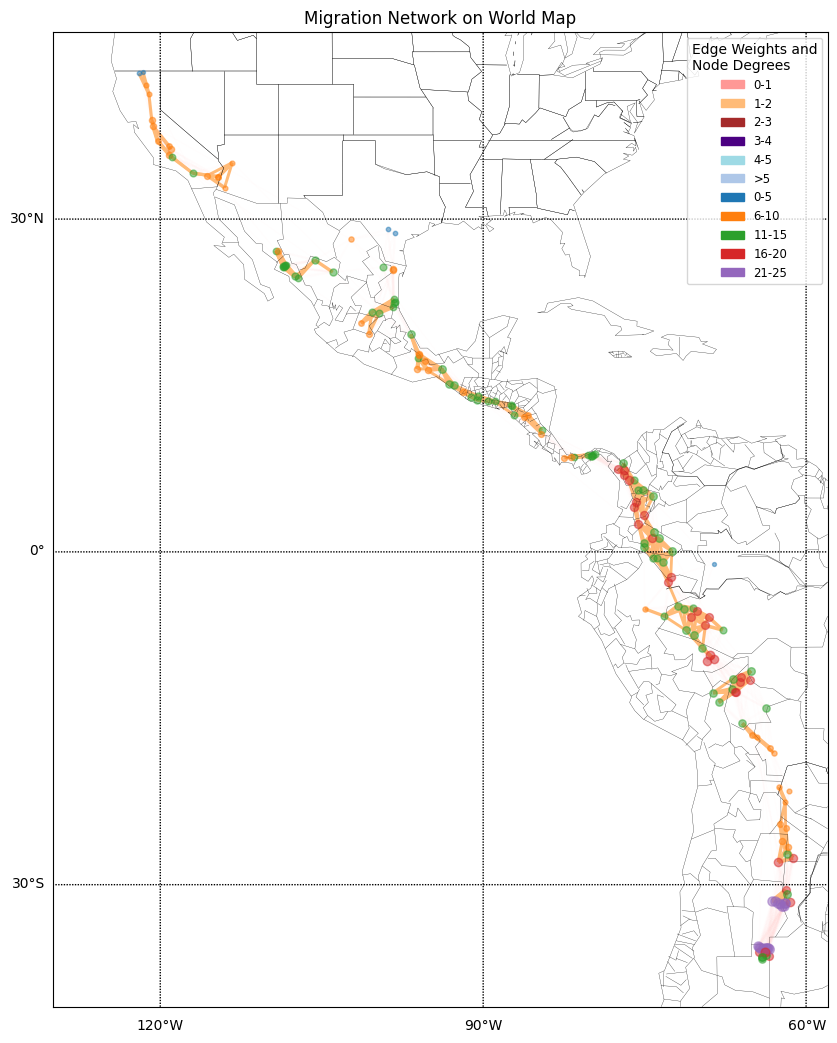

In [48]:
plot_weighted_migration_network_on_world_map(SWH_network)

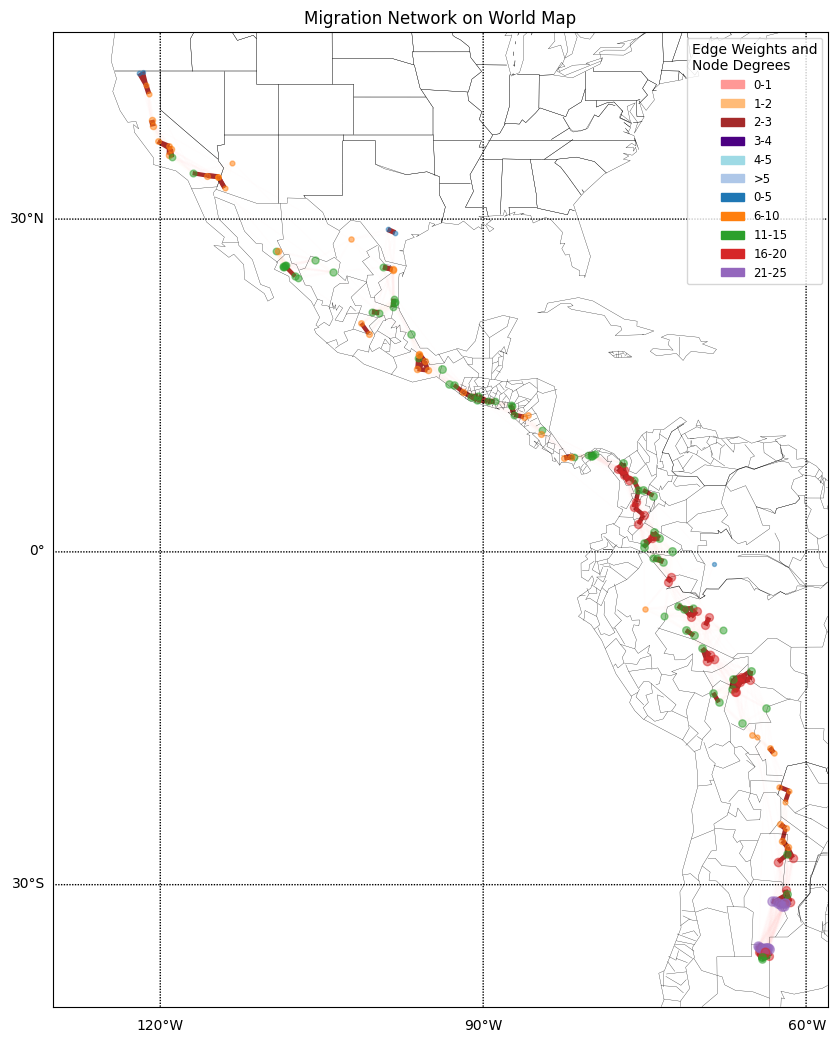

In [42]:
plot_weighted_migration_network_on_world_map(SWH_network)

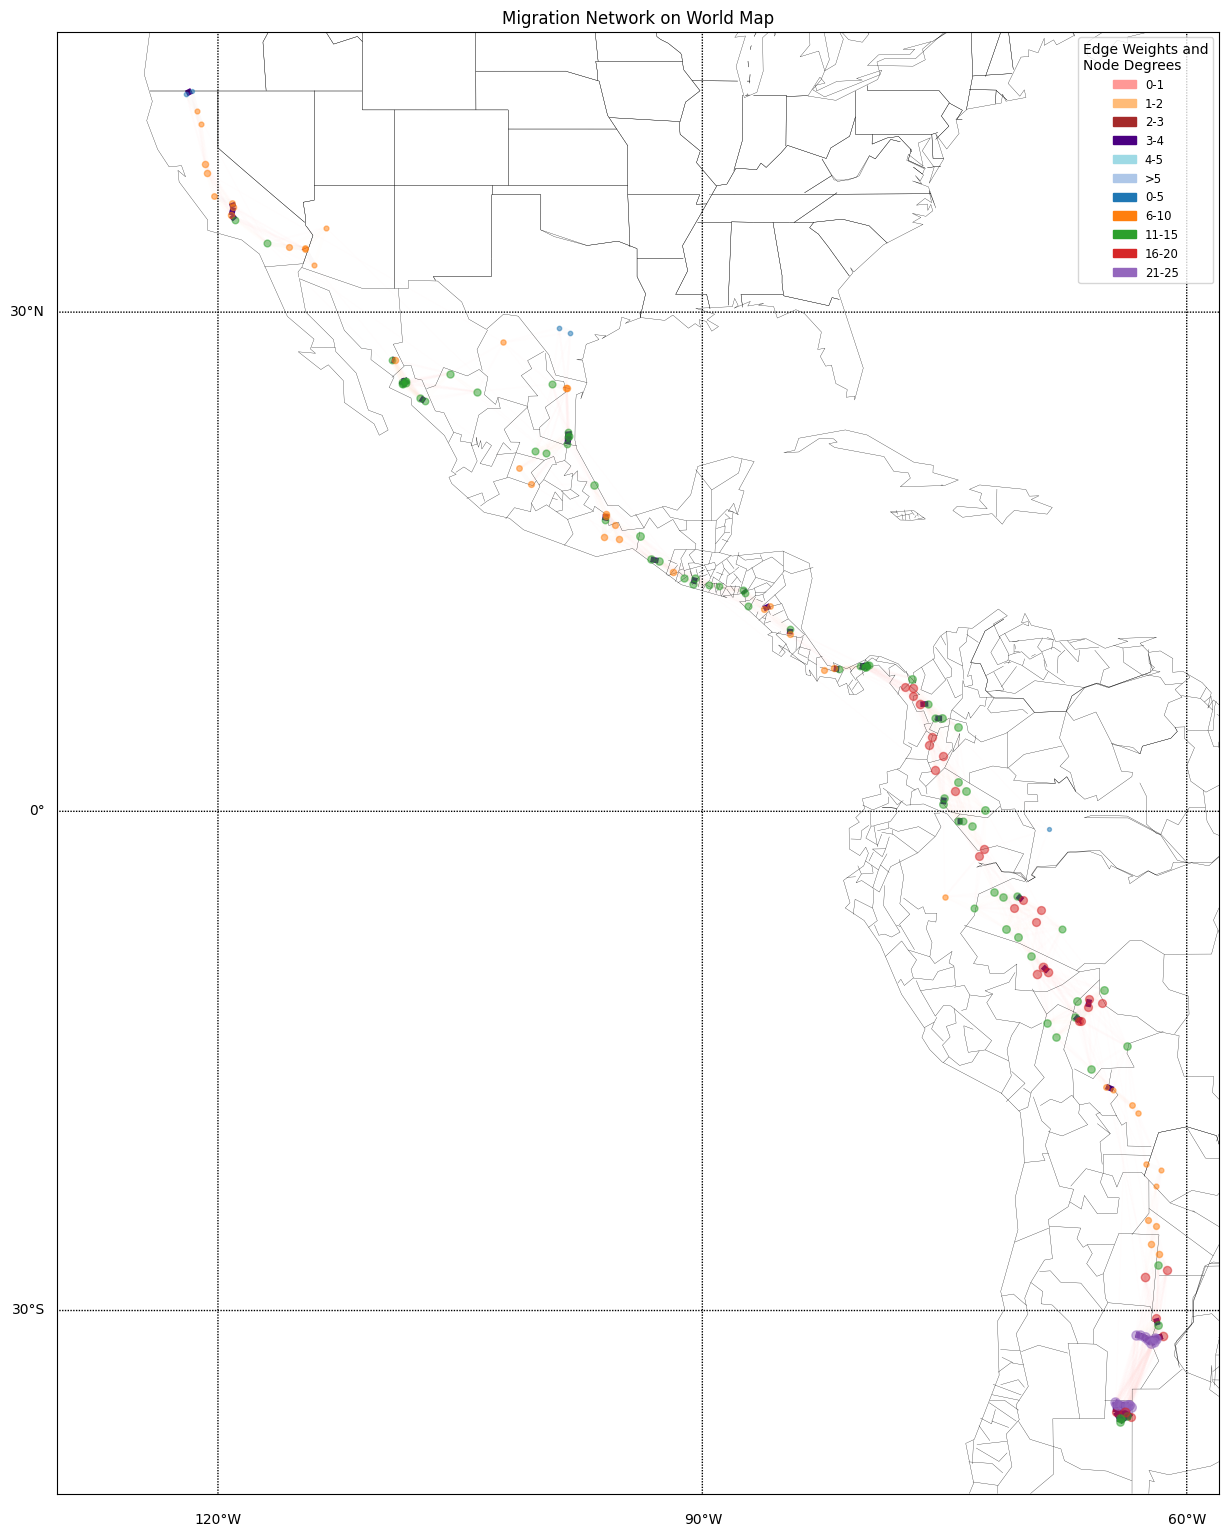

In [46]:
plot_weighted_migration_network_on_world_map(SWH_network)

In [93]:
def plot_weighted_migration_network_on_world_map(migration_network):
    # Create a new figure
    plt.figure(figsize=(10, 20))

    # Create a Basemap instance for world map projection
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-58)

    # Draw coastlines, countries, and states with reduced opacity
    m.drawcoastlines(linewidth=0.2)
    m.drawcountries(linewidth=0.2)
    m.drawstates(linewidth=0.2)

    # Draw meridians and parallels
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert latitude and longitude coordinates to map coordinates
    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}
    
    # Create color maps for edges and nodes based on weight and degree ranges
    # Define colors for edge weight ranges
    edge_colors = ['violet', 'grey', 'brown', 'indigo', 'pink']  
    # Define colors for node degree ranges
    degree_colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']   
    
    # Define edge weight ranges and corresponding labels
    edge_weight_ranges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
    edge_labels = [f'{start}-{end}' for start, end in edge_weight_ranges]
    
    # Define node degree ranges and corresponding labels
    node_degree_ranges = [(5, 10), (11, 15), (16, 20), (21, 25), (26, 30), (31, 35)]
    degree_labels = [f'{start}-{end}' for start, end in node_degree_ranges]
    
    # Draw nodes
    for node, degree in migration_network.degree():
        # Assign node size based on degree
        node_size = degree
        
        # Assign color based on node degree range
        for i, (start, end) in enumerate(node_degree_ranges):
            if start <= degree <= end:
                node_color = degree_colors[i]
                break
        
        nx.draw_networkx_nodes(migration_network, pos, nodelist=[node], node_size=node_size, node_color=node_color, alpha=0.5)
    
    # Draw edges
    for edge in migration_network.edges():
        # Get edge weight
        weight = migration_network[edge[0]][edge[1]].get('weight', 4)  # Default weight to 1 if not set
        
        if weight==4: print(f"weight not found for {edge}")
        # if weight<1:
        #     a = 0.1
        # elif weight<2:
        #     a = 0.2
        # elif weight<3:
        #     a = 0.4
        # else:
        #     a = 0.8
        a = 0.5

        # Assign color based on edge weight range
        for i, (start, end) in enumerate(edge_weight_ranges):
            if start <= weight < end:
                edge_color = edge_colors[i]
                break
        
        nx.draw_networkx_edges(migration_network, pos, edgelist=[edge], width=weight + 1, edge_color=edge_color, alpha=a)
    
    # Create legend patches for edge colors and node degrees
    edge_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(edge_colors, edge_labels)]
    degree_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(degree_colors, degree_labels)]
    
    # Draw legend for both edge colors and node degrees
    plt.legend(handles=edge_patches + degree_patches, title='Edge Weights and\nNode Degrees', loc='upper right', fontsize='small')

    plt.title('Migration Network on World Map')
    plt.show()

# Initial Network

In [82]:
SWH_migratory_stretch = 676
SWH_median_migration = 165
SWH_mean_migration = 205

In [83]:
SWH_network = create_migration_network(df, SWH_migratory_stretch, keep=True)
print(SWH_network)

Graph with 167 nodes and 1566 edges


1


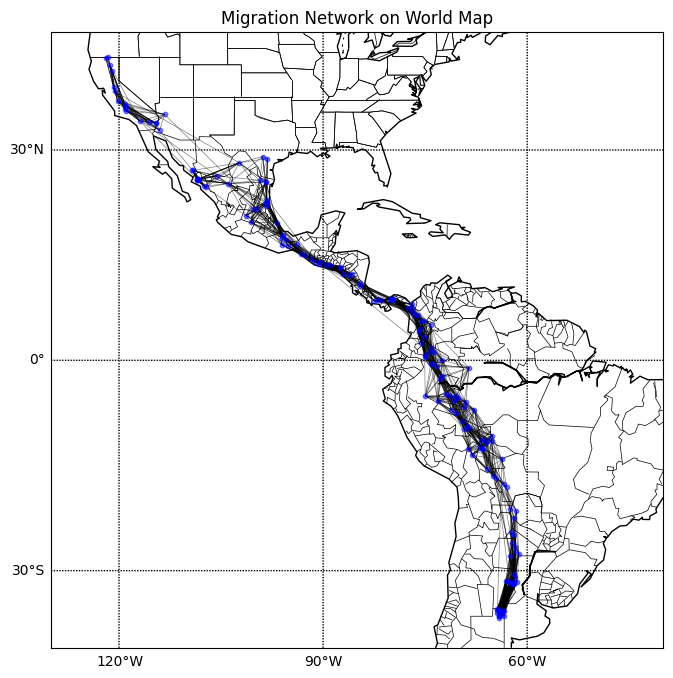

In [85]:
print(len(list(nx.connected_components(SWH_network))))
plot_migration_network_on_world_map(SWH_network)

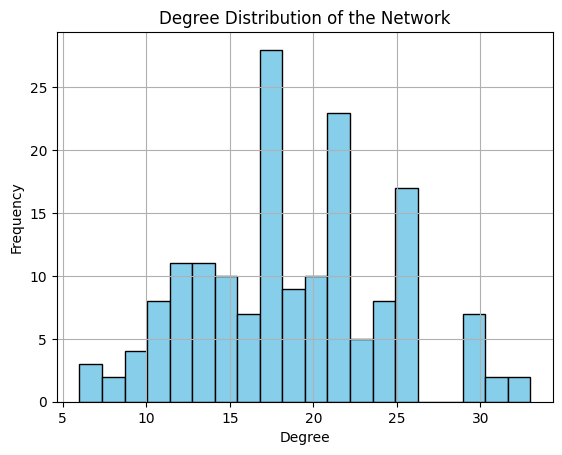

In [90]:
degrees = dict(SWH_network.degree())
# Plot degree distribution
plt.hist(list(degrees.values()), bins=20, color='skyblue', edgecolor='black')
plt.title('Degree Distribution of the Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [86]:
k_SWH = estimate_k_bisection(SWH_median_migration)
print("Estimated value of Dispersal Constant, k:", k_SWH)

n_SWH = df["birdID"].nunique()
print("No. of Swainson's Hawk, n :", n_SWH)

for u, v in SWH_network.edges():
    weight = weight_of_edge(n_SWH, k_SWH, haversine(u[0], u[1], v[0], v[1]))
    SWH_network[u][v]['weight'] = weight

Estimated value of Dispersal Constant, k: 0.004150390625
No. of Swainson's Hawk, n : 4


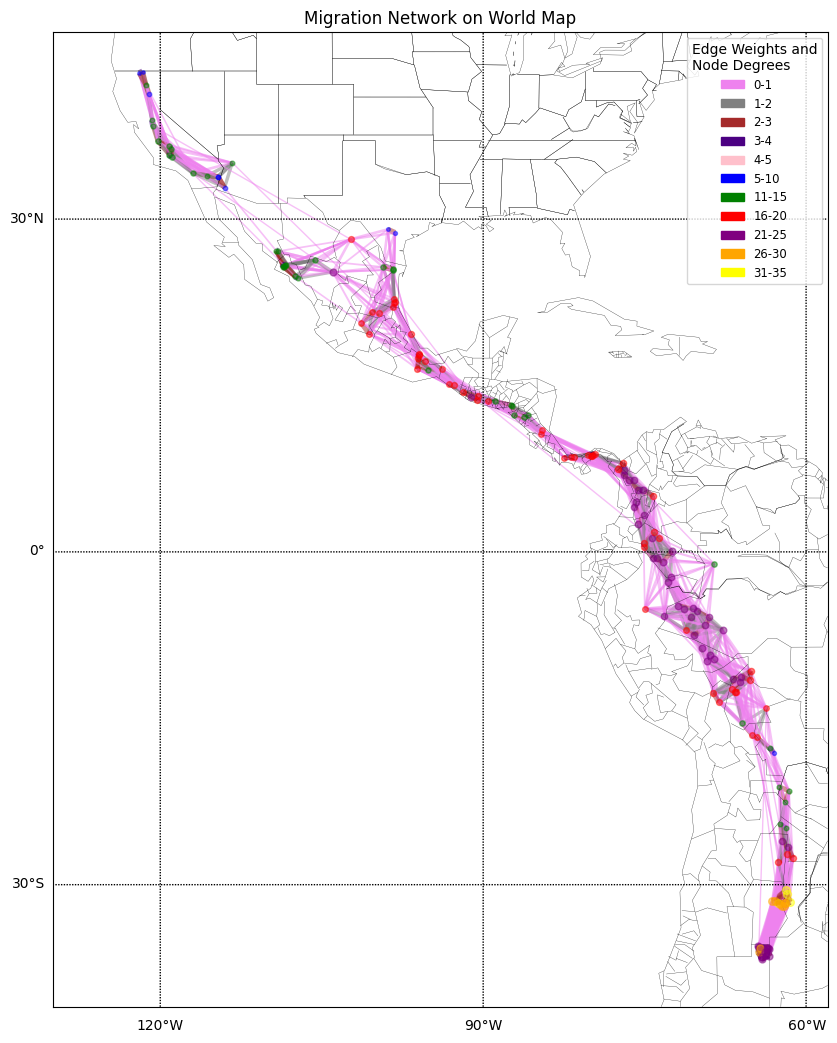

In [94]:
plot_weighted_migration_network_on_world_map(SWH_network)

# Node Locator

In [131]:
def plot_migration_network_vul(migration_network, vulnerable : list, nI=False):
    fig = plt.figure(figsize=(10, 8))
    
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    # Create a list of colors for the nodes
    colors = []
    vul_nodes = []

    for node in migration_network.nodes():
        # Check if the node is in the intersection of the rectangles
        if vulnerable[0] <= node[0] <= vulnerable[1] and vulnerable[2] >= node[1] >= vulnerable[3]:
            colors.append('yellow')
            vul_nodes.append(node)
        else:
            colors.append('blue')

    print(f"Vulnerable nodes = {len(vul_nodes)}: {vul_nodes}")

    # Draw the nodes with the specified colors
    nx.draw_networkx_nodes(migration_network, pos, node_size=10, node_color=colors, alpha=0.5)
    # nx.draw_networkx_edges(migration_network, pos, width=0.5, alpha=0.5)

    if True:
        # Define the latitude and longitude range for the horizontal rectangle
        lower_left_lat = vulnerable[0]
        lower_left_lon = -180
        upper_right_lat = vulnerable[1]
        upper_right_lon = 180

        # Convert the latitude and longitude to map coordinates
        lower_left_x, lower_left_y = m(lower_left_lon, lower_left_lat)
        upper_right_x, upper_right_y = m(upper_right_lon, upper_right_lat)

        # Create a horizontal rectangle
        rect_horizontal = mpatches.Rectangle((lower_left_x, lower_left_y), upper_right_x - lower_left_x, upper_right_y - lower_left_y,
                                linewidth=1, edgecolor='r', facecolor='r', alpha=0.4)

        # Add the horizontal rectangle to the plot
        plt.gca().add_patch(rect_horizontal)

        # Define the latitude and longitude range for the vertical rectangle
        lower_left_lat = -90
        lower_left_lon = vulnerable[2]
        upper_right_lat = 90
        upper_right_lon = vulnerable[3]

        # Convert the latitude and longitude to map coordinates
        lower_left_x, lower_left_y = m(lower_left_lon, lower_left_lat)
        upper_right_x, upper_right_y = m(upper_right_lon, upper_right_lat)

        # Create a vertical rectangle
        rect_vertical = mpatches.Rectangle((lower_left_x, lower_left_y), upper_right_x - lower_left_x, upper_right_y - lower_left_y,
                                linewidth=1, edgecolor='r', facecolor='r', alpha=0.4)

        # Add the vertical rectangle to the plot
        plt.gca().add_patch(rect_vertical)

    plt.title('Migration Network on World Map')
    if nI : plt.show()
    else: return fig

In [123]:
node = (13.873, -87.871)
vulnerable = [13,14,-87,-88]
vulnerable[0] <= node[0] <= vulnerable[1] and vulnerable[2] <= node[1] <= vulnerable[3]

False

Vulnerable nodes = 2: [(13.432, -87.335), (13.601, -87.456)]


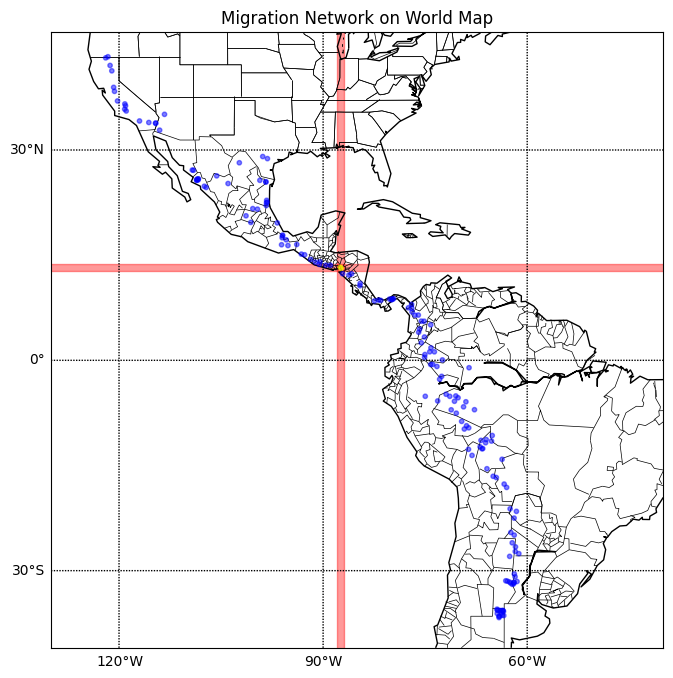

In [132]:
plot_migration_network_vul(SWH_network, [13,14,-87,-88], True)

Vulnerable nodes = 0: []


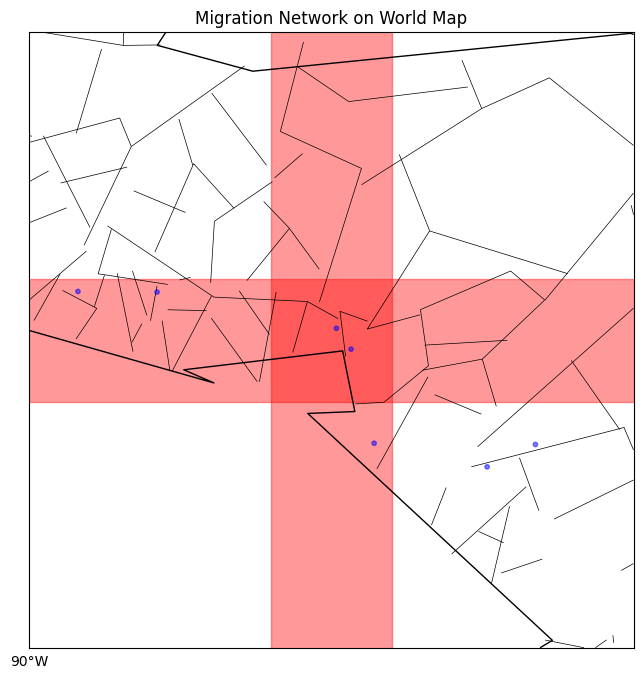

In [114]:
plot_migration_network_vul(SWH_network, [13,14,-87,-88], True)

None

FloatSlider(value=11.600000000000001, description='vulnerable[0]', max=45.0, min=-40.0)

FloatSlider(value=18.4, description='vulnerable[1]', max=45.0, min=-40.0)

FloatSlider(value=-86.5, description='vulnerable[2]', max=-40.0, min=-130.0)

FloatSlider(value=-93.8, description='vulnerable[3]', max=-40.0, min=-130.0)

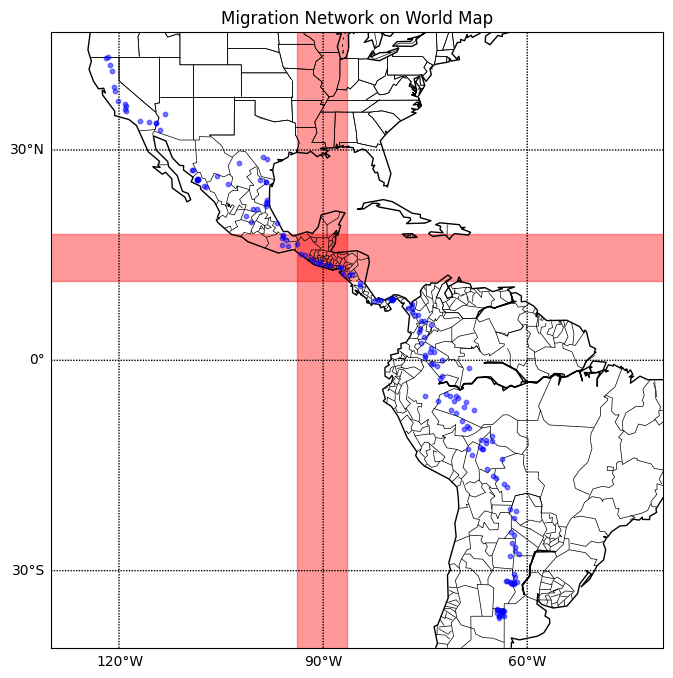

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create sliders for the vulnerable values
slider1 = widgets.FloatSlider(min=-40, max=45, step=0.1, description='vulnerable[0]')
slider2 = widgets.FloatSlider(min=-40, max=45, step=0.1, description='vulnerable[1]')
slider3 = widgets.FloatSlider(min=-130, max=-40, step=0.1, description='vulnerable[2]')
slider4 = widgets.FloatSlider(min=-130, max=-40, step=0.1, description='vulnerable[3]')

# Display the sliders
display(slider1, slider2, slider3, slider4)

# Define a function to update the plot when the slider values change
def update_plot(change):
    clear_output(wait=True)
    vulnerable = [slider1.value, slider2.value, slider3.value, slider4.value]
    fig = plot_migration_network_vul(SWH_network, vulnerable)  # Get the figure from the function
    display(fig)  # Display the figure
    display(slider1, slider2, slider3, slider4)

# Add the update function as a callback for when the slider values change
slider1.observe(update_plot, 'value')
slider2.observe(update_plot, 'value')
slider3.observe(update_plot, 'value')
slider4.observe(update_plot, 'value')

# Call the plot function initially
vulnerable = [slider1.value, slider2.value, slider3.value, slider4.value]
plot_migration_network_vul(SWH_network, vulnerable)

In [133]:
def vulnerable_nodes(migration_network, vulnerable):
    vul_nodes = []

    for node in migration_network.nodes():
        if vulnerable[0] <= node[0] <= vulnerable[1] and vulnerable[2] >= node[1] >= vulnerable[3]:
            vul_nodes.append(node)

    return vul_nodes

vulnerable_nodes(SWH_network, [13,14,-87,-88])

[(13.432, -87.335), (13.601, -87.456)]

In [138]:
def delete_vulnerable_nodes(network, vulnerable):
    # Create a copy of the network
    network_copy = network.copy()
    
    # Find vulnerable nodes
    vuln_nodes = vulnerable_nodes(network, vulnerable)
    
    # Delete vulnerable nodes from the network
    network_copy.remove_nodes_from(vuln_nodes)
    
    # Check the number of connected components
    num_components = nx.number_connected_components(network_copy)
    
    return num_components

delete_vulnerable_nodes(SWH_network, [15,30,-90,-120])

2

Vulnerable nodes = 4: [(-21.495, -62.512), (-22.796, -61.923), (-21.854, -61.586), (-24.79, -62.407)]


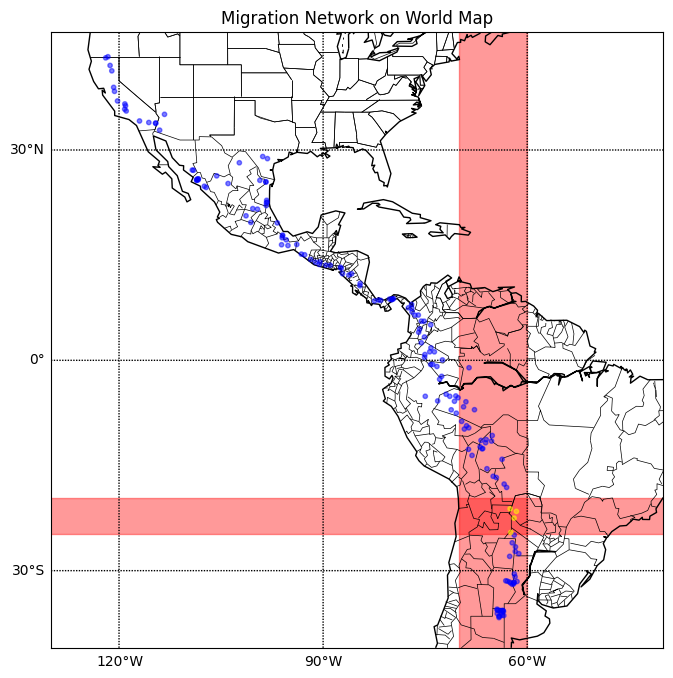

In [140]:
plot_migration_network_vul(SWH_network, [-25,-20,-60,-70], True)

In [139]:
delete_vulnerable_nodes(SWH_network, [-25,-20,-60,-70])

1

# Bird Trail Creation

In [143]:
group1 = df[df["birdID"] == "SW16"]
group2 = df[df["birdID"] == "SW17"]
group3 = df[df["birdID"] == "SW18"]
group4 = df[df["birdID"] == "SW25"]

In [145]:
# Create an empty undirected graph for each group
SWH_16 = nx.Graph()
SWH_17 = nx.Graph()
SWH_18 = nx.Graph()
SWH_25 = nx.Graph()

# Function to add edges to a graph from a group
def add_edges_from_group(graph, group):
    # Sort the group by timestamp if necessary
    group = group.sort_values('date')
    
    # Get the points in the group
    points = list(group[['latitude', 'longitude']].itertuples(index=False, name=None))
    
    # Add an edge between each pair of consecutive points
    for i in range(len(points) - 1):
        graph.add_edge(points[i], points[i + 1])

# Add edges to the graphs from the groups
add_edges_from_group(SWH_16, group1)
add_edges_from_group(SWH_17, group2)
add_edges_from_group(SWH_18, group3)
add_edges_from_group(SWH_25, group4)

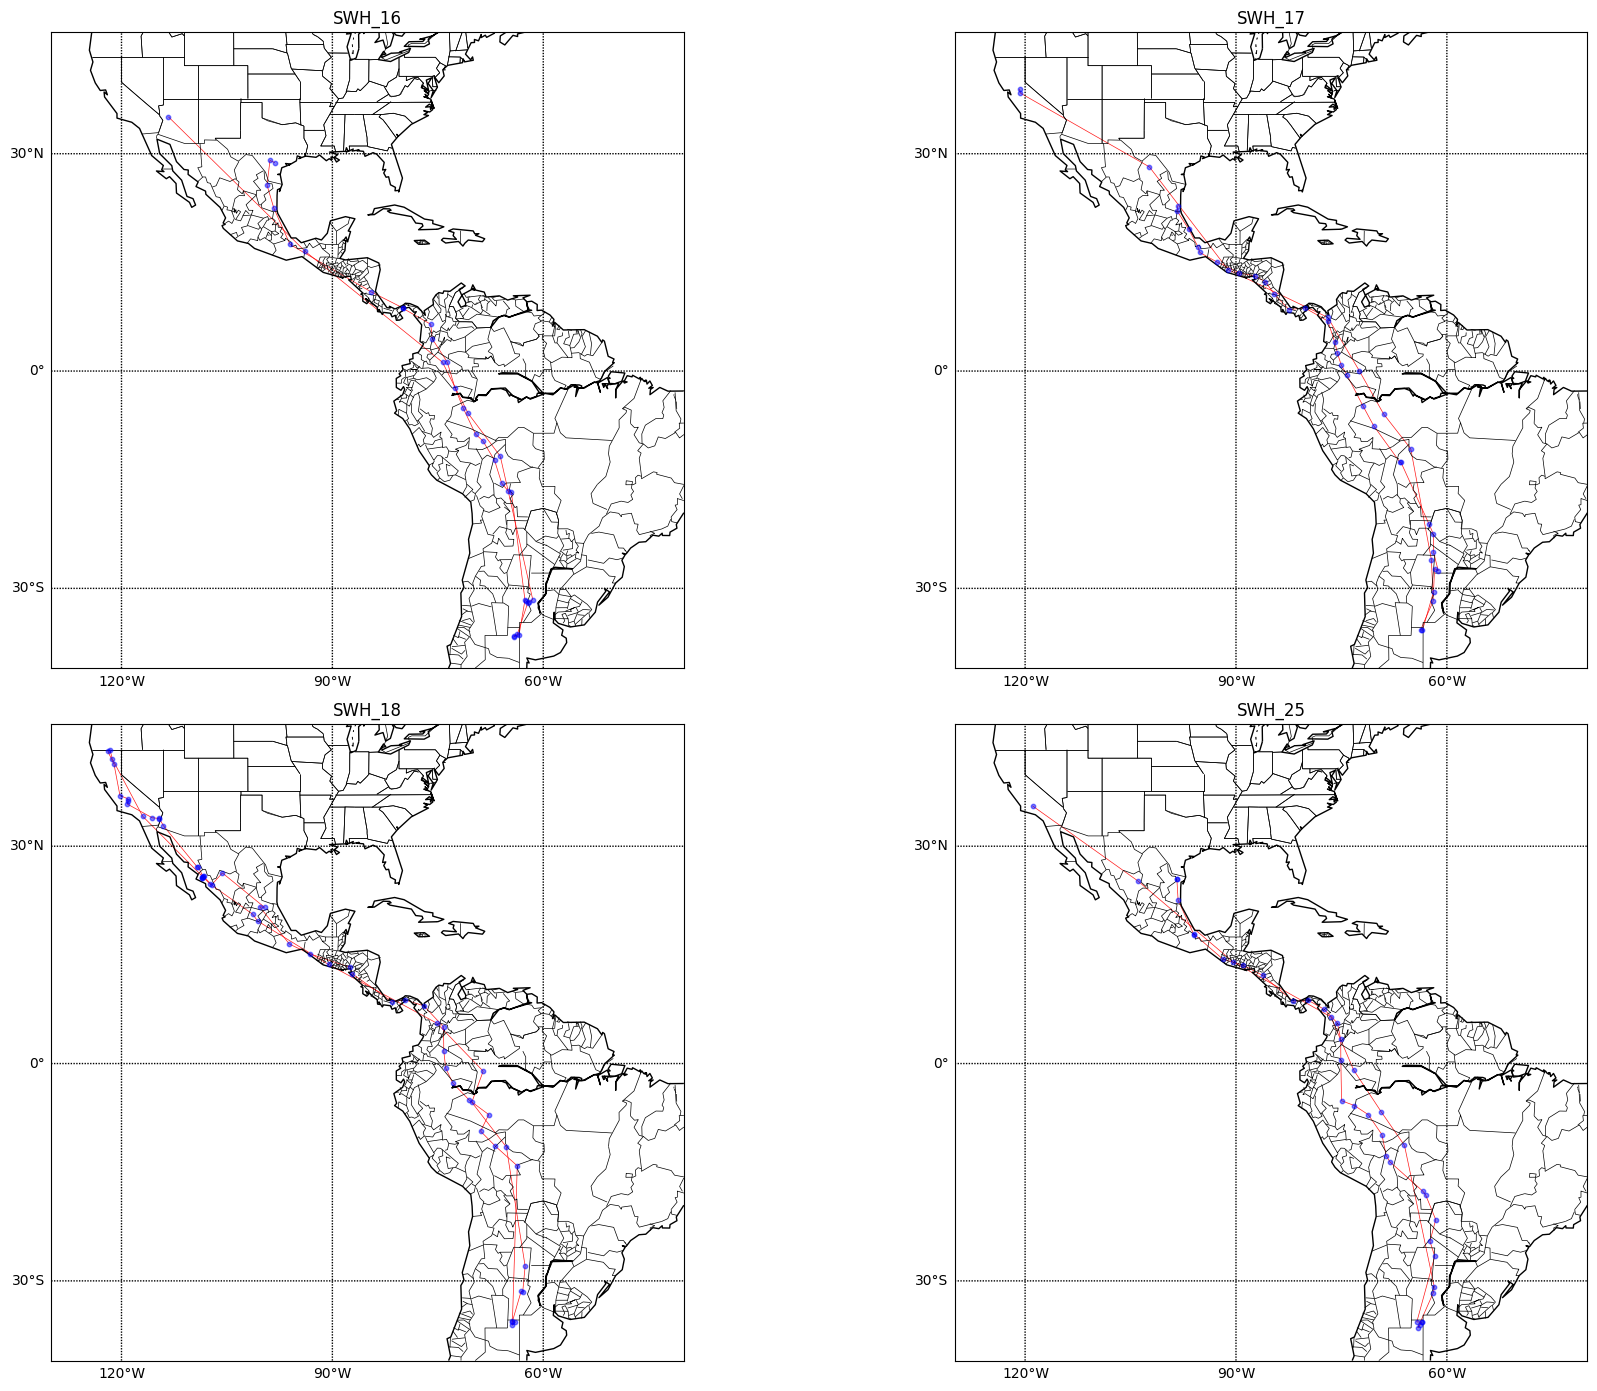

In [153]:
def plot_trail_on_world_map(migration_network, ax):
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    nx.draw_networkx_nodes(migration_network, pos, node_size=10, node_color='blue', alpha=0.5, ax=ax)
    nx.draw_networkx_edges(migration_network, pos, width=0.5, edge_color='red',alpha=0.9, ax=ax)

fig, axs = plt.subplots(2, 2, figsize=(20, 14))

plot_trail_on_world_map(SWH_16, axs[0, 0])
axs[0, 0].set_title('SWH_16')

plot_trail_on_world_map(SWH_17, axs[0, 1])
axs[0, 1].set_title('SWH_17')

plot_trail_on_world_map(SWH_18, axs[1, 0])
axs[1, 0].set_title('SWH_18')

plot_trail_on_world_map(SWH_25, axs[1, 1])
axs[1, 1].set_title('SWH_25')

plt.tight_layout()
plt.show()

# Shortest Trail Traversal